In [79]:
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

In [80]:
# 데이터 로드
only_value = pd.read_csv('result_only_value.csv')
agg_value = pd.read_csv('result_agg_value.csv')
der_profit = pd.read_csv('result_der_profit.csv')
R = pd.read_csv('result_R.csv')
R_avg = pd.read_csv('R_avg.csv')   
alpha_DA = pd.read_csv('result_alpha_DA.csv')
x_DA = pd.read_csv('result_total_X_DA.csv')

In [81]:
# alpha_DA와 x_DA의 차이가 가장 큰 시간대를 찾는 코드
diff = alpha_DA['alpha_DA'] - x_DA['total_x_da_1']
max_diff_index = diff.idxmax()
print(f"alpha_DA와 x_DA의 차이가 가장 큰 시간대는 {max_diff_index}입니다.")


alpha_DA와 x_DA의 차이가 가장 큰 시간대는 13입니다.


In [105]:
generation_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_generation.csv")
generation_q['Time'] = pd.to_datetime(generation_q['Time'], format='%Y-%m-%d %H:%M')
generation_q['Hour'] = generation_q['Time'].dt.floor('H') 
generation_h = generation_q.groupby('Hour').sum(numeric_only=True)  

demand_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_demand.csv")
demand_q['Time'] = pd.to_datetime(demand_q['Time'], format='%Y-%m-%d %H:%M')
demand_q['Hour'] = demand_q['Time'].dt.floor('H')   
demand_h = demand_q.groupby('Hour').sum(numeric_only=True)  

price_q = pd.read_csv("C:/Users/symply_jina/Desktop/seohyun/UIC4801/DATA_price.csv")
price_q['Time'] = pd.to_datetime(price_q['Time'], format='%Y-%m-%d %H:%M')

I = list(range(len(generation_q.columns) - 2))
T = list(generation_q['Time'].dt.hour.unique())
S = list(range(50))
prob = {s: 1 / len(S) for s in S}

generation_avg = {
    (i, t): generation_h[generation_h.index.hour == t].mean()[i] for i in I for t in T
}

def generate_randomized_generation(I, T, S, generation_avg, randomness_level):
    np.random.seed(7)
    if randomness_level == 'low':
        noise_factors = {(i, t, s): np.random.uniform(0.8, 1.2) for i in I for t in T for s in S}
    elif randomness_level == 'medium':
        noise_factors = {(i, t, s): np.random.uniform(0.5, 1.5) for i in I for t in T for s in S}
    elif randomness_level == 'high':
        noise_factors = {(i, t, s): np.random.uniform(0.2, 1.8) for i in I for t in T for s in S}
    else:
        raise ValueError("Invalid randomness level. Please choose 'low', 'medium', or 'high'.")
    
    generation_r = {
        (i, t, s): generation_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
    }
    return generation_r

demand_avg = {
    (i, t): demand_h[demand_h.index.hour == t].mean()[i] for i in I for t in T
}

def generate_randomized_demand(I, T, S, demand_avg, randomness_level):
    np.random.seed(17)
    if randomness_level == 'low':
        noise_factors = {(i, t, s): np.random.uniform(0.8, 1.2) for i in I for t in T for s in S}
    elif randomness_level == 'medium':
        noise_factors = {(i, t, s): np.random.uniform(0.5, 1.5) for i in I for t in T for s in S}
    elif randomness_level == 'high':
        noise_factors = {(i, t, s): np.random.uniform(0.2, 1.8) for i in I for t in T for s in S}
    else:
        raise ValueError("Invalid randomness level. Please choose 'low', 'medium', or 'high'.")
    
    demand_r = {
        (i, t, s): demand_avg[(i, t)]*noise_factors[(i, t, s)] for i in I for t in T for s in S
    }
    return demand_r

random_key = 'medium'
generation_r = generate_randomized_generation(I, T, S, generation_avg, random_key)
demand_r = generate_randomized_demand(I, T, S, demand_avg, random_key)
residual = {(i, t, s): generation_r[(i, t, s)] - demand_r[(i, t, s)] for i in I for t in T for s in S}

R = {
    (i, t, s): max(0, residual[(i, t, s)])
    for i in I for t in T for s in S
}
unique_days = generation_q['Time'].dt.normalize().unique()
days = len(unique_days)
S = list(range(min(len(S), days)))

price_q['Hour'] = price_q['Time'].dt.floor('H')
price_h = price_q.groupby('Hour').mean(numeric_only=True)  

price = price_h.iloc[:len(S)*len(T)]

P_DA = {t: sum(price['Price'].iloc[t + s * len(T)] for s in S) / len(S) * 1.2 for t in T}
P_RT = {(t, s): price['Price'].iloc[t + s * len(T)] for t in T for s in S}
P_PN = {t: sum(price['Price'].iloc[t + s * len(T)] for s in S) / len(S) * 2 for t in T}

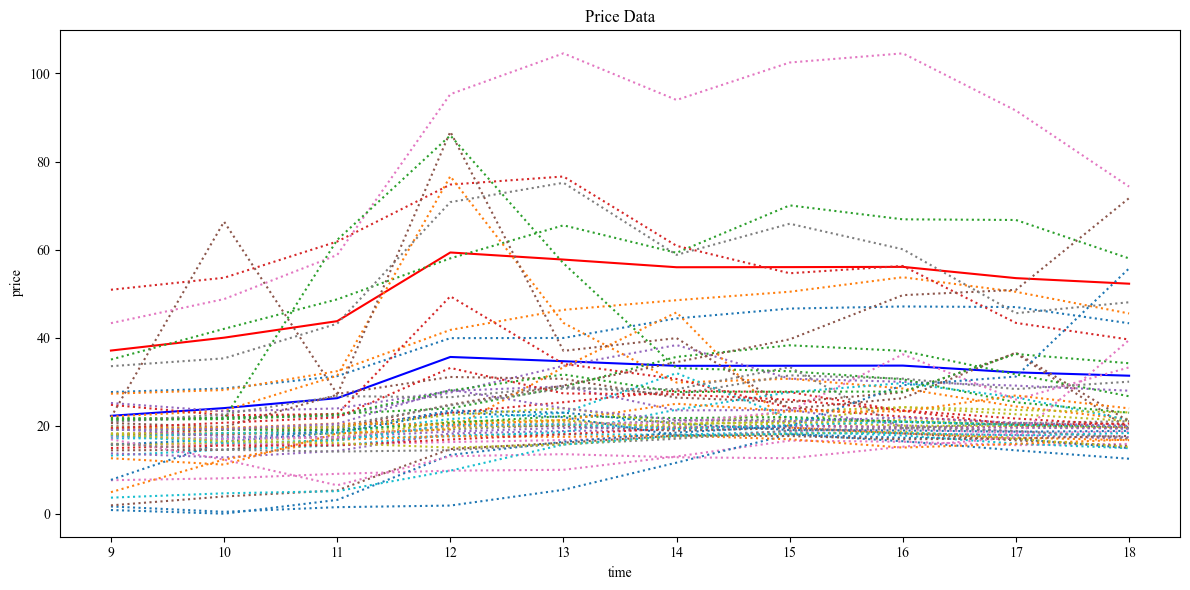

In [108]:
plt.figure(figsize=(12, 6))
plt.plot([t for t in T if t >= 9 and t <= 18], [P_DA[t] for t in T if t >= 9 and t <= 18], 'b-', label='DA price')
plt.plot([t for t in T if t >= 9 and t <= 18], [P_PN[t] for t in T if t >= 9 and t <= 18], 'r-', label='Penalty price')

for s in S:
    plt.plot([t for t in T if t >= 9 and t <= 18], [P_RT[t, s] for t in T if t >= 9 and t <= 18], ':', label=f'RT price (s={s})')

plt.xticks(range(9, 19, 1))
plt.title('Price Data')
plt.xlabel('time')
plt.ylabel('price')
plt.grid(False)  # 격자를 없애기 위해 False로 설정
# plt.legend()
plt.tight_layout()
plt.show()

Plotting

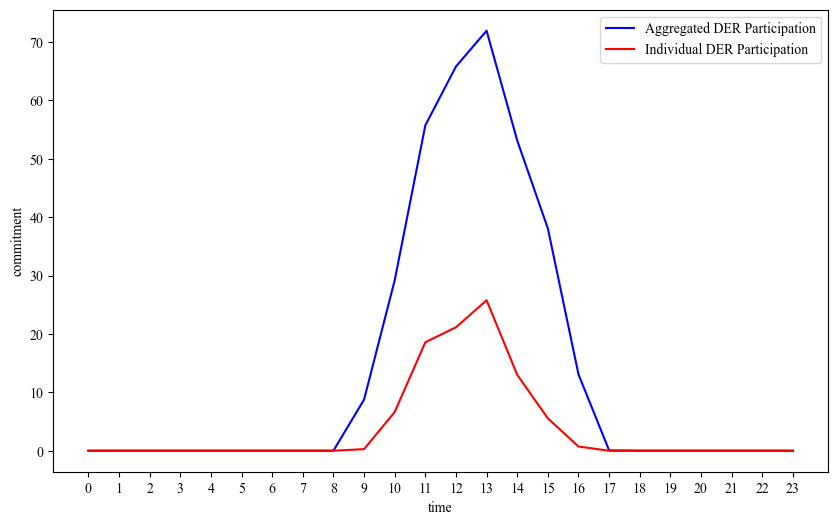

In [82]:
plt.figure(figsize=(10,6))
plt.plot(alpha_DA['alpha_DA'], label='Aggregated DER Participation', color='blue')
plt.plot(x_DA['total_x_da_1'], label='Individual DER Participation', color='red')
plt.xticks(np.arange(min(alpha_DA.index), max(alpha_DA.index)+1, 1.0))
plt.xlabel('time')
plt.ylabel('commitment')
plt.legend()
plt.rc('font', family='Times New Roman')
plt.show()

### profit renumeration

In [83]:
R

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.395617,0.000000,0.050479,0.353198,0.000000,0.000000,0.136758,0.049985,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,2.274049,0.564618,1.510345,1.631360,0.462389,0.000000,1.812310,0.576796,0.614076,0.540290,0.157105,0.000000,0.576656,0.239208,0.361824,0.344676,0.357531,0.157911,0.015321


In [84]:
R_proportion = R.div(R.sum(axis=1), axis=0).fillna(0)

In [85]:
R_proportion

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.401219,0.000000,0.051194,0.358200,0.000000,0.000000,0.138695,0.050693,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.186452,0.046294,0.123835,0.133757,0.037912,0.000000,0.148593,0.047292,0.050349,0.044299,0.012881,0.000000,0.047281,0.019613,0.029666,0.028260,0.029314,0.012947,0.001256


가격 고려 안한 평균 ver

In [86]:
R_noprice = R_proportion.sum(axis=0)

In [87]:
proportion_noprice = R_noprice / R_noprice.sum()
proportion_noprice

0     0.105206
1     0.036162
2     0.068703
3     0.094760
4     0.036150
5     0.034532
6     0.106833
7     0.174386
8     0.035413
9     0.040571
10    0.022679
11    0.004472
12    0.056443
13    0.030861
14    0.032857
15    0.030004
16    0.007866
17    0.050609
18    0.031493
dtype: float64

In [88]:
surplus = float(agg_value['agg_value'].iloc[0]) - float(only_value['only_value'].iloc[0])
excess = surplus * proportion_noprice
# excess
aggregated_der_profit_noprice = pd.DataFrame(columns=der_profit.columns)

for i in range(len(der_profit)):
    aggregated_der_profit_noprice.loc[i] = der_profit.iloc[i] + excess.iloc[i]

In [89]:
aggregated_der_profit_noprice

,der_profit_value
0,1057.754656
1,645.637757
2,1036.528901
3,955.354585
4,597.105927
5,559.258775
6,1307.083884
7,1060.884875
8,472.047973
9,662.965925


가중평균 version

In [90]:
P_DA = P_DA['price'].values

# R_proportion에 P_DA값을 곱해주는 코드
R_proportion_P = R_proportion.multiply(P_DA, axis=0)

In [91]:
R_proportion_P

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,8.927688,0.000000,1.139141,7.970451,0.000000,0.000000,3.086152,1.127988,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,4.146026,1.029407,2.753647,2.974280,0.843024,0.000000,3.304186,1.051609,1.119578,0.985052,0.286432,0.000000,1.051354,0.436121,0.659675,0.628410,0.651847,0.287901,0.027932


In [92]:
R_p = R_proportion_P.sum(axis=0)


In [93]:
R_p


0     30.590219
1     11.950054
2     21.982766
3     28.103981
4     12.158325
5     12.504442
6     34.504560
7     60.021562
8     12.022192
9     13.774072
10     7.734149
11     1.550142
12    19.115553
13    10.479618
14    11.050168
15    10.274278
16     2.293719
17    17.902830
18    11.242615
dtype: float64

In [94]:
proportion = R_p / R_p.sum()

surplus 나누기

In [95]:
surplus = float(agg_value['agg_value'].iloc[0]) - float(only_value['only_value'].iloc[0])
# surplus

In [96]:
excess = surplus * proportion
# excess

In [97]:
aggregated_der_profit = pd.DataFrame(columns=der_profit.columns)

for i in range(len(der_profit)):
    aggregated_der_profit.loc[i] = der_profit.iloc[i] + excess.iloc[i]

In [98]:
der_profit

,der_profit_value
0,912.565741
1,595.732949
2,941.715098
3,824.581017
4,547.217836
5,511.602942
6,1159.649105
7,820.223647
8,423.176978
9,606.976066


In [99]:
aggregated_der_profit

,der_profit_value
0,1040.782319
1,645.820690
2,1033.854189
3,942.376717
4,598.178533
5,564.014359
6,1304.272346
7,1071.799459
8,473.567083
9,664.709040


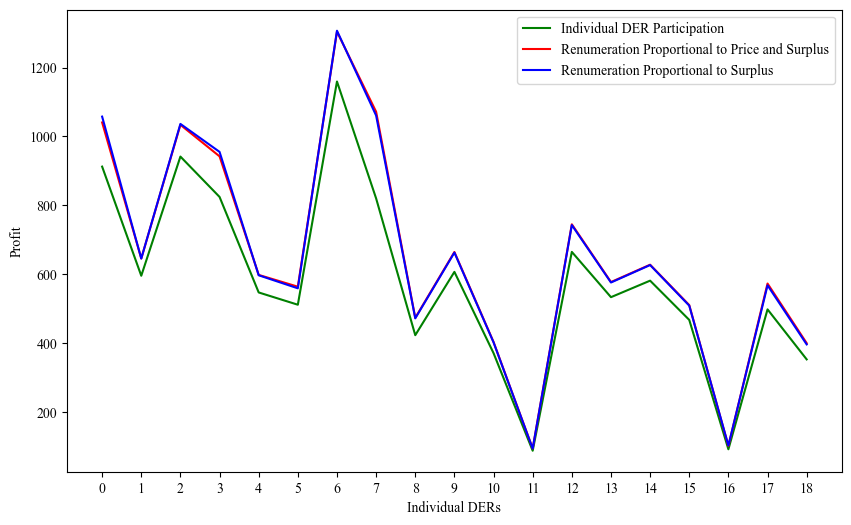

In [100]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(der_profit, label='Individual DER Participation', color='green')
plt.plot(aggregated_der_profit, label='Renumeration Proportional to Price and Surplus', color='red')
plt.plot(aggregated_der_profit_noprice, label='Renumeration Proportional to Surplus', color='blue')

plt.xlabel('Individual DERs')
plt.ylabel('Profit')
plt.xticks(range(len(der_profit)), range(len(der_profit)))
plt.legend()
plt.show()


profit 증가율

In [101]:
increase = (aggregated_der_profit - der_profit) / der_profit * 100
increase_noprice = (aggregated_der_profit_noprice - der_profit) / der_profit * 100

In [102]:
increase

,der_profit_value
0,14.050120
1,8.407751
2,9.784179
3,14.285522
4,9.312689
5,10.244550
6,12.471293
7,30.671612
8,11.907572
9,9.511573


In [103]:
increase_noprice

,der_profit_value
0,15.909968
1,8.377043
2,10.068205
3,15.859396
4,9.116679
5,9.315004
6,12.713741
7,29.340928
8,11.548595
9,9.224393


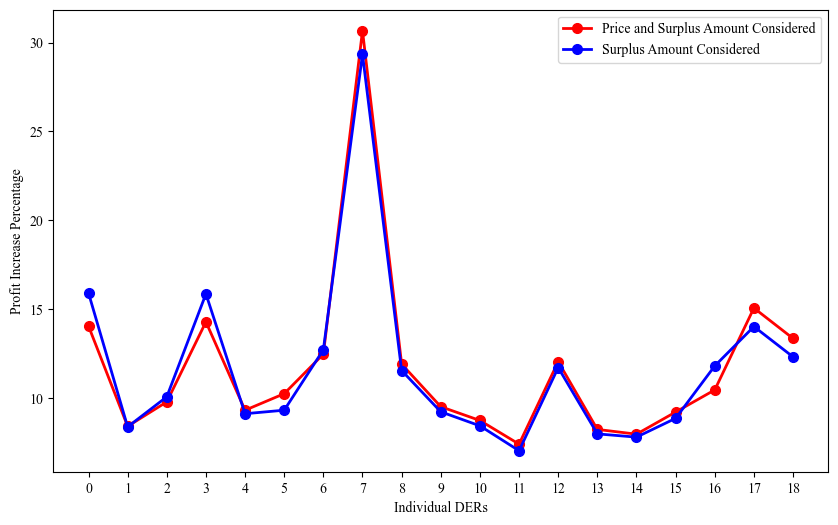

<Figure size 640x480 with 0 Axes>

In [109]:
plt.figure(figsize=(10, 6))
plt.plot(increase, label='Price and Surplus Amount Considered', 
         marker='o', color='red', linestyle='-', linewidth=2, markersize=7)
plt.plot(increase_noprice, label='Surplus Amount Considered', 
         marker='o', color='blue', linestyle='-', linewidth=2, markersize=7)

plt.xlabel('Individual DERs', fontsize=13)
plt.ylabel('Profit Increase Percentage', fontsize=13)
plt.xticks(range(len(increase)), range(len(increase)))
plt.legend()
plt.show()

plt.savefig('fig_renumeration.pdf', bbox_inches='tight', pad_inches=0.05)
